In [1]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn.model_selection import train_test_split


dataset = pd.read_csv('/Users/eddie/Downloads/Log In - AgInjuryNews (1).xlsx - Sheet1 (1) - Log In - AgInjuryNews (1).xlsx - Sheet1 (1).csv')

X = pd.DataFrame(dataset.iloc[:,:18].values)
Y = pd.DataFrame(dataset.iloc[:,18:].values)
print(X)
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
X_train, X_train_val, Y_train, Y_train_val = train_test_split(X,Y,test_size=0.2)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

features = pd.DataFrame(dataset.iloc[:,:18])
features = features.columns
print(features)

      0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17
0      3   2   2  25   0   3  10   0   0   0   0   0   0   0   0   0   1   1
1      3   3   1  61   0   3  10   0   0   0   0   0   0   0   0   0   7   1
2      3   3   1  65   0   3  10   0   0   0   0   0   0   0   0   0   6   1
3      3   2   1  49   0   3  10   0   0   0   1   0   0   0   0   0   5   1
4      3   1   1  54   0   5   2   1   1   0   0   0   0   0   0   1   5   1
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3414   1   2   1  57   0   6   7   0   0   0   0   0   0   0   0   0   1   4
3415   1   1   1  24   0   3   7   0   0   0   0   0   0   0   0   0   1   4
3416   1   1   1  50   0   3  10   0   0   0   0   0   0   0   0   0   6   4
3417   1   2   1  58   0   3   9   0   0   0   0   0   0   0   0   0   6   4
3418   1   2   1   3   0   4  10   0   0   0   0   0   0   0   0   0   5   4

[3419 rows x 18 columns]
      0
0     0
1     1
2     1
3     0
4     1
..

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [3]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(18,)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  hp_units2 = hp.Int('units2', min_value=24, max_value=64, step=8)
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units2, activation='relu'))

  hp_units3 = hp.Int('units3', min_value=4, max_value=24, step=4)
  model.add(keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4,1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [4]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape = (18,)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='ann_hyper',
                     project_name='ann_hyper')


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 22s]
val_accuracy: 0.4003656208515167

Best val_accuracy So Far: 0.6435100436210632
Total elapsed time: 00h 03m 21s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256 and the optimal learning rate for the optimizer
is 0.001.



In [7]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.2)

Epoch 1/500
69/69 [==============================] - 15s 24ms/step - loss: 0.6865 - accuracy: 0.3684 - val_loss: 0.6828 - val_accuracy: 0.4004
Epoch 2/500
69/69 [==============================] - 0s 7ms/step - loss: 0.6726 - accuracy: 0.3684 - val_loss: 0.6747 - val_accuracy: 0.4004
Epoch 3/500
69/69 [==============================] - 1s 9ms/step - loss: 0.6596 - accuracy: 0.4013 - val_loss: 0.6695 - val_accuracy: 0.6271
Epoch 4/500
69/69 [==============================] - 1s 13ms/step - loss: 0.6478 - accuracy: 0.5946 - val_loss: 0.6488 - val_accuracy: 0.6325
Epoch 5/500
69/69 [==============================] - 1s 17ms/step - loss: 0.6367 - accuracy: 0.6079 - val_loss: 0.6538 - val_accuracy: 0.6325
Epoch 6/500
69/69 [==============================] - 1s 16ms/step - loss: 0.6370 - accuracy: 0.6257 - val_loss: 0.6455 - val_accuracy: 0.6380
Epoch 7/500
69/69 [==============================] - 1s 22ms/step - loss: 0.6343 - accuracy: 0.6042 - val_loss: 0.6520 - val_accuracy: 0.5795
Epoch 8

In [8]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 470


In [9]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train, Y_train, epochs=467, validation_split=0.2)

Epoch 1/467
69/69 [==============================] - 20s 33ms/step - loss: 0.6715 - accuracy: 0.4374 - val_loss: 0.6697 - val_accuracy: 0.4004
Epoch 2/467
69/69 [==============================] - 1s 10ms/step - loss: 0.6484 - accuracy: 0.5571 - val_loss: 0.6506 - val_accuracy: 0.6399
Epoch 3/467
69/69 [==============================] - 1s 16ms/step - loss: 0.6399 - accuracy: 0.5914 - val_loss: 0.6504 - val_accuracy: 0.6344
Epoch 4/467
69/69 [==============================] - 1s 14ms/step - loss: 0.6396 - accuracy: 0.5663 - val_loss: 0.6459 - val_accuracy: 0.6252
Epoch 5/467
69/69 [==============================] - 1s 12ms/step - loss: 0.6336 - accuracy: 0.6092 - val_loss: 0.6407 - val_accuracy: 0.5740
Epoch 6/467
69/69 [==============================] - 1s 7ms/step - loss: 0.6323 - accuracy: 0.6037 - val_loss: 0.6376 - val_accuracy: 0.6161
Epoch 7/467
69/69 [==============================] - 0s 7ms/step - loss: 0.6319 - accuracy: 0.5969 - val_loss: 0.6479 - val_accuracy: 0.5649
Epoch 8

In [10]:
res = hypermodel.predict(X_test)
res.round()
actual = []
for num in res:
    if num>0.5:
        actual.append(1)
    else:
        actual.append(0)
from sklearn.metrics import classification_report
print(classification_report(Y_test,actual,digits=6))

22/22 [==============================] - 2s 5ms/step


              precision    recall  f1-score   support

           0   0.722846  0.756863  0.739464       255
           1   0.851319  0.827506  0.839243       429

    accuracy                       0.801170       684
   macro avg   0.787083  0.792184  0.789354       684
weighted avg   0.803423  0.801170  0.802045       684



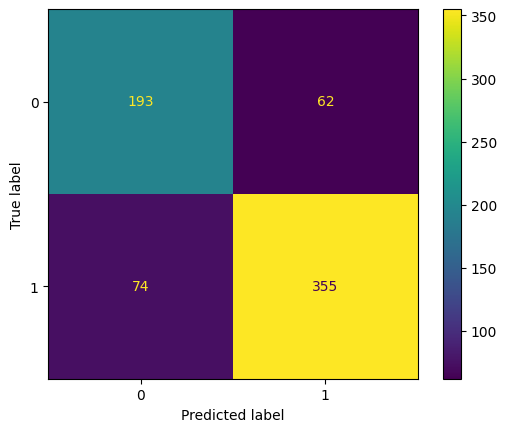

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusionmatrix = confusion_matrix(Y_test, actual)
cm_display = ConfusionMatrixDisplay(confusionmatrix, display_labels=[0,1])
cm_display.plot()